To do 
- Eventually optimize to get another DNN architecture?
- Integrate covariance computation into pipeline (instead of pre-processing)
- visualize covariance matrix
- visualize the scatter plots of the n(n+1)/2 covar points for eqch signs.
- Try SVM (like barachant)
- Try Nina's metrics

# 0. Interactive Cloud Version 
(Select GPU/TPU for faster training of the Tensorflow models).

https://colab.research.google.com/github/MariusGuerard/emg_sign_recognition/blob/master/somos_data_analysis.ipynb

In [23]:
# Set to true if run in colab
RUN_IN_COLAB = False

In [24]:
if RUN_IN_COLAB:
    # Installing non-colab library.
    !pip install pyriemann
    
    # Downloading custom library (not available with pip)
    !wget https://raw.githubusercontent.com/MariusGuerard/emg_sign_recognition/master/helper_function.py \
        -O /tmp/helper_function.py
    !wget https://raw.githubusercontent.com/MariusGuerard/emg_sign_recognition/master/viz.py \
        -O /tmp/viz.py

    ### Add the tmp directory to the path to be able to import the custom libraries.
    import sys
    sys.path.append('/tmp/')

    ### Downloading and extracting the data
    !wget https://github.com/MariusGuerard/emg_sign_recognition/blob/master/data/data_somos.zip?raw=true\
        -O /tmp/data_somos.zip
    !unzip -o /tmp/data_somos.zip -d /tmp/data_somos/
    # Directory of the data
    data_dir = '/tmp/data_somos/JAN20/'
    
else:
    data_dir = 'data/data_somos/JAN20/'

# Start of the notebook if ran in local

In [25]:
import os, pickle
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from os.path import join
from glob import glob
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import seaborn as sns
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
#from tensorflow.keras import Sequential
tf.__version__

import pyriemann
from pyriemann.tangentspace import TangentSpace

import helper_function as hf
import viz

In [26]:
# Number of splits in the K_Fold (for intra-session only)
N_SPLIT = 3
### Number of hardware acquisitions to consider as a trial.
# The higher the number of steps, the longer the decision time but the better the accuracy.
# With current hardware, the sampling frequency is 4ms, so N_STEPS of 100 correspond to trial time (decision time) of 400ms
N_STEPS = 100

In [27]:
dic_result = {}

In [28]:
#!gsutil rsync -r gs://data_somos/ .

# 1. Preliminary comments

In [29]:
# Labels that correspond to the order (0 = Nothing, 1 = Rock, ...)
label_dic = {'Nothing': 0, 'Rock': 1, 'Paper': 2, 'Scissors': 3, 'Ok': 4}

# 2. Loading the Data.

In [30]:
#data_dir = 'data/data_somos/JAN20/' 

read_somos_csv = lambda path: pd.read_csv(path, sep=',', names = ['time', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'label'], skiprows=1)

def combine_pd(pattern, data_dir=data_dir):
    df = pd.concat([read_somos_csv(x) for x in glob(data_dir + pattern + 'txt')])
    df['exp'] = [pattern] * len(df)
    return df

In [31]:
patterns = ['mg*s1*', 'mg*s2*', 'rr*s1*', 'rr*s2*']

In [32]:
data_df = pd.concat([combine_pd(pattern) for pattern in patterns])

In [33]:
data_df.sample(10)

,time,c0,c1,c2,c3,c4,c5,c6,c7,label,exp
979,4027,127,128,127,127,129,128,129,127,0,rr*s2*
15720,64510,130,126,127,130,123,127,127,129,2,rr*s1*
1682,7062,128,128,127,127,132,127,129,128,0,rr*s2*
20945,85966,130,125,140,129,126,125,121,125,3,mg*s1*
17495,71833,126,126,120,128,127,127,128,130,2,mg*s2*
7824,31673,127,124,137,133,121,124,124,124,1,rr*s2*
14074,57753,129,128,127,129,128,125,128,130,2,mg*s1*
8115,33495,132,128,128,128,126,129,128,126,1,mg*s2*
20097,82393,122,132,128,126,128,132,125,137,3,mg*s1*
26066,106930,130,126,132,128,130,129,129,127,4,rr*s1*


In [34]:
data_df.describe()

,time,c0,c1,c2,c3,c4,c5,c6,c7,label
count,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000
mean,62558.191848,127.505144,127.507004,127.506409,127.504250,127.505813,127.506537,127.505465,127.503991,2.001328
std,36043.299100,3.565628,4.235870,3.714308,2.794727,2.724745,2.384146,2.779323,2.851516,1.413178
min,4.000000,61.000000,48.000000,27.000000,53.000000,82.000000,54.000000,54.000000,44.000000,0.000000
25%,31345.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,1.000000
50%,62552.000000,128.000000,128.000000,127.000000,127.000000,128.000000,128.000000,128.000000,128.000000,2.000000
75%,93800.750000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,3.000000
max,125014.000000,190.000000,245.000000,193.000000,194.000000,217.000000,210.000000,191.000000,249.000000,4.000000


# 3. Pre-processing of the data

## 3.0 Giving same labels sign map as in Kaggle

In [35]:
labels = data_df.label.values

In [36]:
# Changing the resting state 0 into -1
tmp = np.where(labels==0, -1, labels)
# Changing the Rock 1 in Rock 0
tmp = np.where(tmp==1, 0, tmp)
# Changing the Scissor 3 in Scissors 1
tmp = np.where(tmp==3, 1, tmp)
# Changing the Ok 4 in OK 3
labels = np.where(tmp==4, 3, tmp)

In [37]:
data_df.label = labels

For now let's remove the 'rest' sign (to have a better comparison with the MYO), but we can look at it later.

In [38]:
data_df = data_df[data_df.label != -1]

There is two possibilities for the organization of the data:
- Batching: reorganization "kaggle style" (t0_sensor0, ..., t0_sensor8, t1_sensor0, ..., t1_sensor8, ..., t8_sensor8).
- Keep only one time step per row (as it is already).

## 3.1 Batching

Let's organize the data in samples where one sample corresponds to 10 acquisitions at ~250Hz so one sample is ~40ms

In [39]:
data_df.shape

(585888, 11)

In [40]:
start_sign = np.where(np.diff(data_df.label) != 0)[0]
end_sign = np.append(start_sign[1:], len(data_df)) - 1000
start_sign += 1000

We have 24 files with 5 signs each (including rest) so we should have 5 * 24 - 1 = 119 changes of sign, or 4 * 24 - 1 = 95 (in case with no rest)

In [41]:
len(start_sign)

95

Batching the data so that a sample is defined similarly than in the kaggle competition with multiple time step for each channel (t0_c0, t0_c1, ..., t1_c0, t1_c1, ...) 

This step can take a bit of time (~30s)

In [42]:
emg_list = []
label_list = []
exp_list = []
for j in range(len(start_sign)):
    batchs = range(start_sign[j], end_sign[j] - N_STEPS, N_STEPS)
    #print(batchs)
    emg_list.append([data_df.iloc[i: i+N_STEPS, 1: -2].values.flatten() for i in batchs])
    # Similarly to the kaggle data let's create samples of 10 time steps of 8 channel: t0_sensor0, t0_sensor1, ..., t10_sensor0, ..., t10_sensor8.
    label_list.append([data_df.iloc[i, -2] for i in batchs])
    # Similarly to the kaggle data let's create samples of 10 time steps of 8 channel: t0_sensor0, t0_sensor1, ..., t10_sensor0, ..., t10_sensor8.
    exp_list.append([data_df.iloc[i, -1] for i in batchs])
emg = np.concatenate(emg_list)
labels = np.hstack(label_list)
exps = np.hstack(exp_list)

In [43]:
emg.shape

(3856, 800)

### 3.2 Separation in 4 datasets (2 sessions for 2 users)

In [44]:
len(exps)

3856

data_per_exp = {}
for exp_name in patterns:
    idx_exp = np.where(exps==exp_name)[0]
    data_per_exp[exp_name] = {'raw': emg[idx_exp], 'labels': labels[idx_exp]}
    print(len(emg[idx_exp]))

In [45]:
if 'data.pickle' in os.listdir():
    with open('data.pickle', 'rb') as handle:
        data_per_exp = pickle.load(handle)
else:
    data_per_exp = {}
    for exp_name in patterns:
        idx_exp = np.where(exps==exp_name)[0]
        data_per_exp[exp_name] = {'raw': np.float_(emg[idx_exp]), 'labels': labels[idx_exp]}
        print(len(emg[idx_exp]))

931
978
973
974


# 4. Model on each dataset separately

In [46]:
result_intra = {}

In this section, we are just using each dataset separately to both fit and evaluate different models. That gives an idea of the best-case scenario (when the user tries the wrist band just after having calibrating it)

In [47]:
k_fold = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=7)

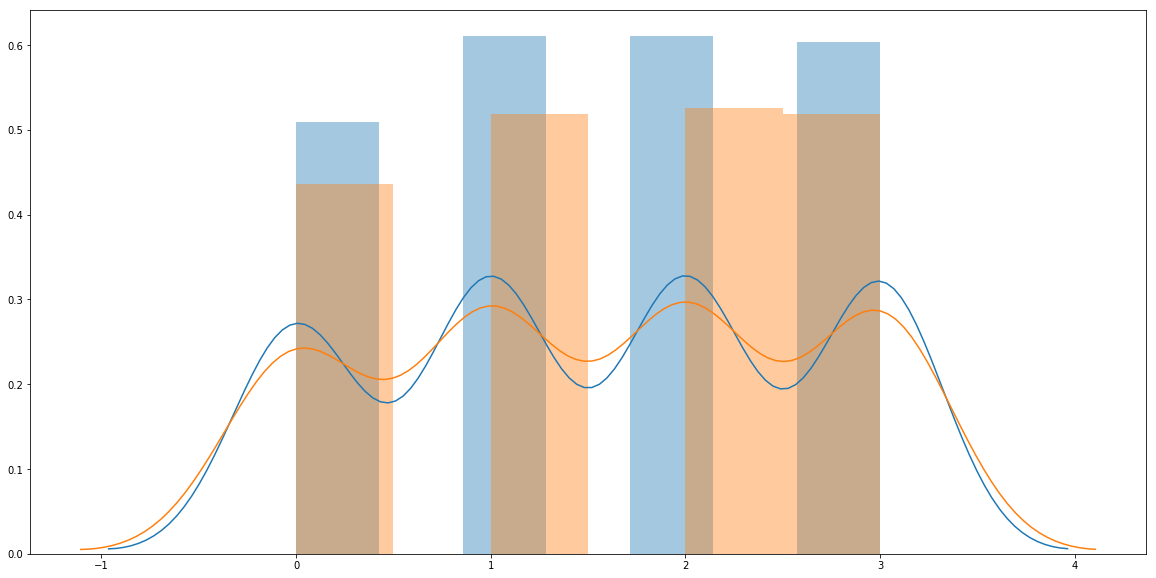

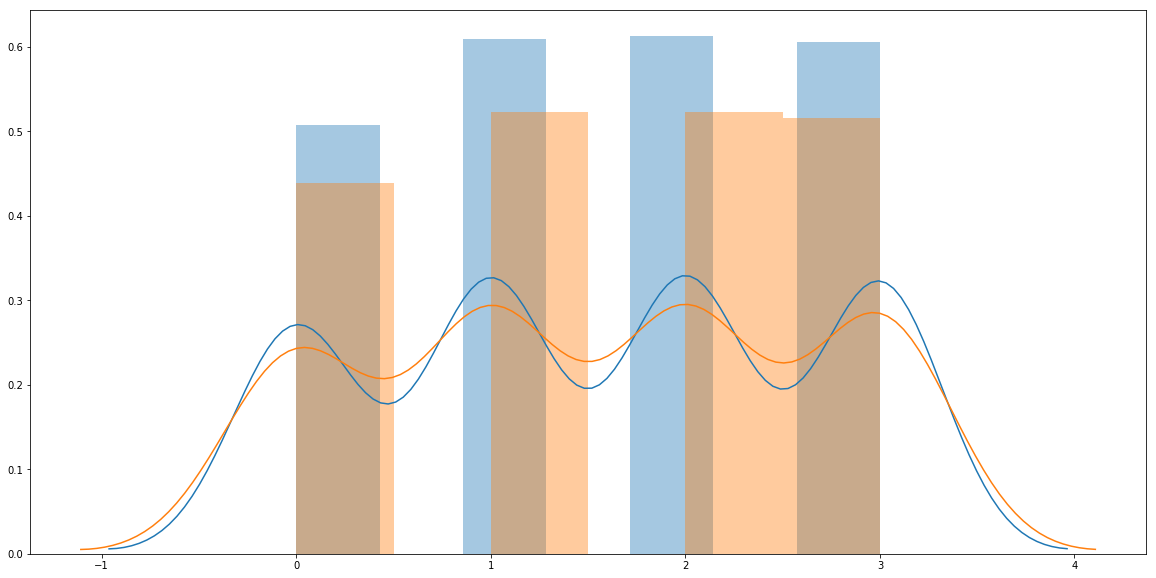

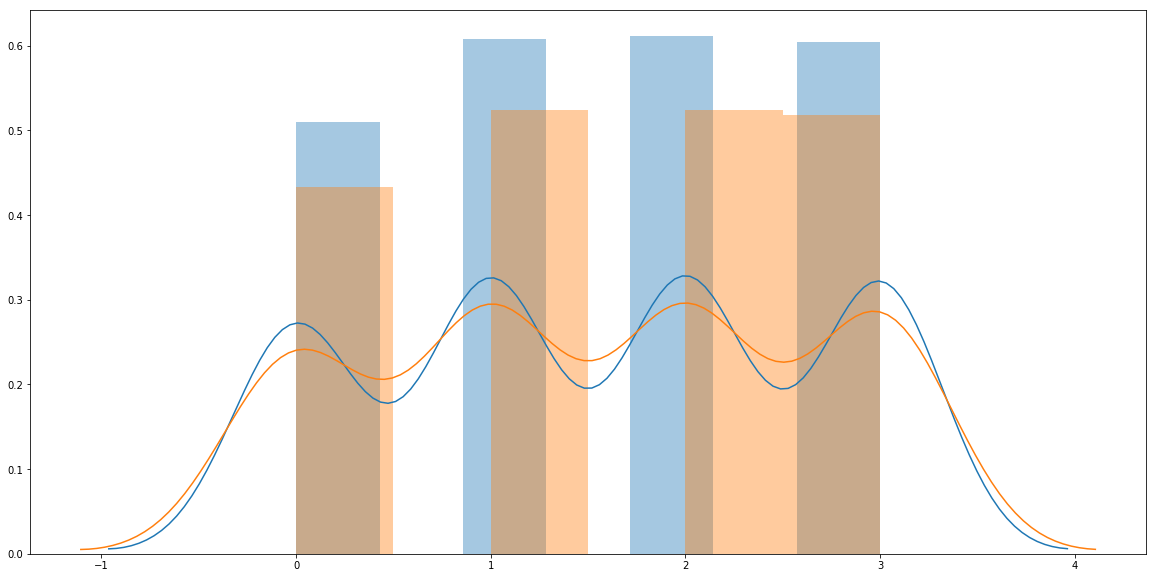

In [48]:
X = data_per_exp['mg*s1*']['raw']
y = data_per_exp['mg*s1*']['labels']
for train_indices, test_indices in k_fold.split(X, y):
    plt.figure()
    sns.distplot(y[train_indices])
    sns.distplot(y[test_indices])

The plots above confirm that the 4 signs are equally represented in our 3 splits.

Storing the accuracy and time results in a dictionary

## 4.1 Using the Row Data

This is if we were to use the models directly on the N_channels x N_time_steps features of a sample. Here it is very important to scale the data, as the signal sent from the FPGA has a very big biais relatively to the signal energy.

### 4.1.0 Naive Model

This random model is used to see what accuracy we would get by guessing randomly what sample corresponds to what sign. In average, we should have 25% accuracy if we have 4 signs and 20% accuracy if we have 5 signs.

In [25]:
class ChanceDetector():
    """Just a random number generator.
    """
    def __init__(self, n_class):
        self.n_class = 4

    def fit(self, X_train, y_train):
        return None
    
    def predict(self, X_test):
        lx = len(X_test)
        return np.random.randint(0, self.n_class, lx)

In [26]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('naive',  ChanceDetector(4)))
pipeline_naive = Pipeline(estimators)

In [27]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_naive, kfold=k_fold, key_result='naive_raw', key_data='raw')

mg*s1* [0.266025641025641, 0.24193548387096775, 0.28802588996763756] 0.26532900495474876
mg*s2* [0.2682926829268293, 0.2553846153846154, 0.23692307692307693] 0.25353345841150715
rr*s1* [0.2331288343558282, 0.26851851851851855, 0.30959752321981426] 0.2704149586980537
rr*s2* [0.2361963190184049, 0.2191358024691358, 0.27469135802469136] 0.24334115983741067


As expected we have scores around 25% using the naive model on each dataset.

### 4.1.1 With Logistic Regression

In [28]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_lr = Pipeline(estimators)

In [29]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_lr, kfold=k_fold, key_result='lr_raw', key_data='raw')

mg*s1* [0.25961538461538464, 0.26129032258064516, 0.2168284789644013] 0.24591139538681037
mg*s2* [0.25609756097560976, 0.28615384615384615, 0.2523076923076923] 0.2648530331457161
rr*s1* [0.27607361963190186, 0.24691358024691357, 0.25386996904024767] 0.2589523896396877
rr*s2* [0.25153374233128833, 0.29012345679012347, 0.2808641975308642] 0.27417379888409205


Barely above chance level

### 4.1.2. With DNN

In [30]:
def create_model(weights='initial_weights.hd5', n_features=800):
    """Function to create model, required for using KerasClassifier and wrapp a Keras modeol inside a 
    scikitlearn form.
    We added a weight saving/loading to remove the randomness of the weight initialization (for better comparison)
    """
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(34, activation='relu', input_shape=(n_features,)),
    tf.keras.layers.Dense(17, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    if weights is None:
        model.save_weights('initial_weights.hd5')
    else:
        model.load_weights(weights)
    return model

In [31]:
generate_weights = create_model(weights=None)

W0321 14:36:06.276942 140238354560768 deprecation.py:506] From /home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [32]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model, epochs=100, verbose=0)))
pipeline_dnn = Pipeline(estimators)

In [33]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_dnn, kfold=k_fold, key_result='dnn_raw', key_data='raw')

mg*s1* [0.28846153846153844, 0.2838709677419355, 0.2524271844660194] 0.2749198968898311
mg*s2* [0.28353658536585363, 0.31076923076923074, 0.3169230769230769] 0.30374296435272047
rr*s1* [0.3374233128834356, 0.30246913580246915, 0.2693498452012384] 0.3030807646290477
rr*s2* [0.2822085889570552, 0.2932098765432099, 0.2962962962962963] 0.29057158726552046


## 4.2 Using Covariances

Just as for EEG, most of the information should be contains in the covariance matrix of each sample.
For 8 channels and 10 time steps sample, this matrix will have dimension 8x8

In [34]:
i = start_sign[0]
data_df.iloc[i: i+10]

,time,c0,c1,c2,c3,c4,c5,c6,c7,label,exp
13206,54156,123,127,127,128,127,128,127,127,2,mg*s1*
13207,54159,127,129,126,126,127,127,128,128,2,mg*s1*
13208,54162,132,124,123,126,128,127,129,123,2,mg*s1*
13209,54166,129,131,131,126,127,128,130,119,2,mg*s1*
13210,54169,124,130,130,136,124,128,134,123,2,mg*s1*
13211,54172,126,131,129,121,128,130,128,134,2,mg*s1*
13212,54176,131,131,127,125,127,131,121,135,2,mg*s1*
13213,54178,125,130,132,122,128,128,127,130,2,mg*s1*
13214,54181,124,128,130,122,128,131,130,126,2,mg*s1*
13215,54185,129,127,123,125,129,129,131,131,2,mg*s1*


In [49]:
if 'cov.pickle' in os.listdir():
    with open('cov.pickle', 'rb') as handle:
        data_per_exp = pickle.load(handle)
else:
    for key, data in data_per_exp.items():
        # X: your EEG data, in format Ntrials x Nchannels X Nsamples
        emg_rows = data['raw']
        X = np.array([x.reshape(N_STEPS, 8).transpose() for x in emg_rows])
        cov = pyriemann.estimation.Covariances(estimator='lwf').fit_transform(X)
        covec = np.array([hf.vectorize_cov(cov_mat) for cov_mat in cov])
        var = np.array([cov_mat.diagonal() for cov_mat in cov])
        y = data['labels']
        data['matrix'] = X
        data['cov'] = cov
        data['covec'] = covec
        data['var'] = var
    with open('cov.pickle', 'wb') as handle:
        pickle.dump(data_per_exp, handle)

In [36]:
data_per_exp['mg*s1*']['matrix'].shape

(931, 8, 100)

In [37]:
data_per_exp['mg*s1*']['var'].shape

(931, 8)

In [38]:
data_per_exp['mg*s1*']['covec'].shape

(931, 36)

In [39]:
data_per_exp['mg*s1*']['cov'].shape

(931, 8, 8)

### 4.2.1 Logistic Regression on Variance

In [40]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_lr = Pipeline(estimators)

In [41]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_lr, kfold=k_fold, key_result='logreg_var', key_data='var')

mg*s1* [0.967948717948718, 0.9838709677419355, 0.9676375404530745] 0.9731524087145761
mg*s2* [0.9847560975609756, 0.9723076923076923, 0.9692307692307692] 0.9754315196998125
rr*s1* [0.9846625766871165, 0.9907407407407407, 0.9845201238390093] 0.9866411470889555
rr*s2* [0.9846625766871165, 0.9660493827160493, 0.9537037037037037] 0.9681385543689566


Way better results than everything else we tried so far!

### 4.2.2 DNN on Variance

In [42]:
def create_model_variance(weights='initial_weights.hd5'):
    return create_model(weights=weights, n_features=8)

In [43]:
generate_weights = create_model_variance(weights=None)

In [44]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model_variance, epochs=100, verbose=0)))
pipeline_dnn = Pipeline(estimators)

In [45]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_dnn, kfold=k_fold, key_result='dnn_var', key_data='var')

mg*s1* [0.9935897435897436, 0.9967741935483871, 0.9773462783171522] 0.9892367384850943
mg*s2* [0.9908536585365854, 0.9907692307692307, 0.9907692307692307] 0.9907973733583489
rr*s1* [0.99079754601227, 0.9907407407407407, 0.9907120743034056] 0.9907501203521387
rr*s2* [0.9877300613496932, 0.9814814814814815, 0.9598765432098766] 0.9763626953470171


Let's try to add all covariances elements to see if we gain in accuracy.

### 4.2.3 Log Reg on covariance Matrix

In [46]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_logreg = Pipeline(estimators)

In [47]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_logreg, kfold=k_fold, key_result='logreg_covec', key_data='covec')

mg*s1* [0.9743589743589743, 0.9806451612903225, 0.970873786407767] 0.975292640685688
mg*s2* [0.9664634146341463, 0.9569230769230769, 0.9323076923076923] 0.9518980612883051
rr*s1* [0.9846625766871165, 0.9876543209876543, 0.978328173374613] 0.9835483570164613
rr*s2* [0.9846625766871165, 0.9629629629629629, 0.9475308641975309] 0.9650521346158701


### 4.2.4 DNN on covariance Matrix

In [48]:
# Function to create model, required for KerasClassifier
def create_model_covariance(weights='initial_weights.hd5'):
    return create_model(weights=weights, n_features=36)
generate_weights = create_model_covariance(weights=None)

In [49]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model_covariance, epochs=100, verbose=0)))
pipeline_dnn = Pipeline(estimators)

In [50]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_dnn, kfold=k_fold, key_result='dnn_covec', key_data='covec')

mg*s1* [0.9871794871794872, 0.9967741935483871, 0.9741100323624595] 0.986021237696778
mg*s2* [0.9786585365853658, 0.96, 0.9661538461538461] 0.9682707942464038
rr*s1* [0.9815950920245399, 0.9907407407407407, 0.978328173374613] 0.9835546687132979
rr*s2* [0.9877300613496932, 0.9506172839506173, 0.9320987654320988] 0.9568153702441364


(I also ran it with unscaled data and it doesn't seem to change much here as the covariance are already scaled)

### 4.2.5 Euclidean MDM

In [51]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=hf.ClosestMean(), kfold=k_fold, key_result='eucl_mdm_covec', key_data='covec')

mg*s1* [0.9006410256410257, 0.8838709677419355, 0.8511326860841424] 0.8785482264890345
mg*s2* [0.8536585365853658, 0.8523076923076923, 0.8061538461538461] 0.8373733583489681
rr*s1* [0.8220858895705522, 0.8580246913580247, 0.8111455108359134] 0.8304186972548301
rr*s2* [0.852760736196319, 0.8549382716049383, 0.8055555555555556] 0.8377515211189376


In [52]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=hf.ClosestMean(), kfold=k_fold, key_result='eucl_mdm_cov', key_data='cov')

mg*s1* [0.8974358974358975, 0.8741935483870967, 0.8576051779935275] 0.8764115412721739
mg*s2* [0.850609756097561, 0.8523076923076923, 0.803076923076923] 0.8353314571607253
rr*s1* [0.8128834355828221, 0.845679012345679, 0.7987616099071208] 0.8191080192785406
rr*s2* [0.8496932515337423, 0.8518518518518519, 0.8117283950617284] 0.8377578328157741


In [53]:
dic_result.keys()
dic_to_save = {key: value for key,value in dic_result.items() if 'model' not in key}

In [54]:
dic_to_save.keys()

dict_keys([])

In [55]:
with open('result.pickle', 'wb') as handle:
    pickle.dump(dic_to_save, handle)

### 4.2.6 Riemannian MDM

In [56]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pyriemann.classification.MDM(), kfold=k_fold, key_result='riemann_mdm_cov', key_data='cov')

mg*s1* [0.9358974358974359, 0.9032258064516129, 0.883495145631068] 0.9075394626600389
mg*s2* [0.9359756097560976, 0.9446153846153846, 0.9353846153846154] 0.9386585365853658
rr*s1* [0.9386503067484663, 0.9228395061728395, 0.9256965944272446] 0.9290621357828502
rr*s2* [0.9386503067484663, 0.9197530864197531, 0.9104938271604939] 0.9229657401095711


### 4.2.7 Tangeant Space + Log Reg

In [57]:
estimators = []
estimators.append(('ts', TangentSpace()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_tang_lr = Pipeline(estimators)

In [58]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_tang_lr, kfold=k_fold, key_result='ts_logreg_cov', key_data='cov')

mg*s1* [0.9871794871794872, 0.9935483870967742, 0.9838187702265372] 0.9881822148342662
mg*s2* [0.9786585365853658, 0.9723076923076923, 0.9784615384615385] 0.9764759224515321
rr*s1* [0.9938650306748467, 0.9938271604938271, 0.9969040247678018] 0.9948654053121585
rr*s2* [0.9846625766871165, 0.9753086419753086, 0.9722222222222222] 0.9773978136282158


### 4.2.8 Tangeant Space + DNN

In [59]:
# Function to create model, required for KerasClassifier
def create_model_covariance(weights='initial_weights.hd5'):
    return create_model(weights=weights, n_features=36)
generate_weights = create_model_covariance(weights=None)

In [60]:
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('ts', TangentSpace()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model_covariance, epochs=100, verbose=0)))
pipeline_tang_dnn = Pipeline(estimators)

In [61]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_tang_dnn, kfold=k_fold, key_result='ts_dnn_cov', key_data='cov')

mg*s1* [0.9935897435897436, 1.0, 0.9902912621359223] 0.9946270019085554
mg*s2* [0.9969512195121951, 0.9876923076923076, 0.9876923076923076] 0.9907786116322702
rr*s1* [0.9938650306748467, 0.9938271604938271, 0.9845201238390093] 0.9907374383358943
rr*s2* [0.9938650306748467, 0.9876543209876543, 0.9753086419753086] 0.9856093312126032


## 4.3 Plotting intra-sessions results

In [62]:
acc_vec = np.array([acc_model['acc_all'] for key, acc_model in result_intra.items()]).transpose()
model_labels = result_intra.keys()

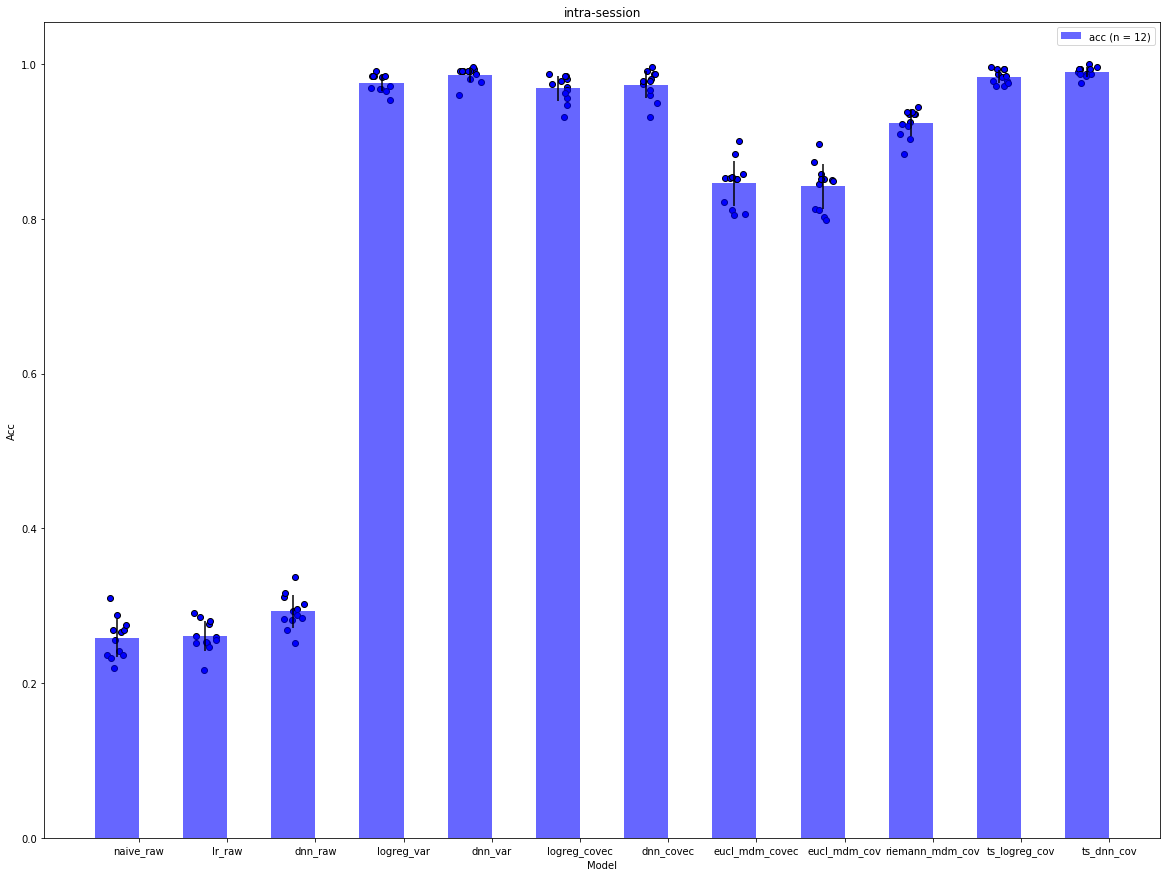

In [63]:
viz.bar_plot_scatter_comp([acc_vec], model_labels, 'intra-session', ['acc'])

We notice that most of the information of the signal seem to be contained in the covariance matrix of the electrodes (and particularly in its diagonal: the variances)

In [65]:
acc_var = np.array([acc_model['acc_all'] for key, acc_model in result_intra.items() if 'raw' not in key]).transpose()
model_labels = [x for x in result_intra.keys() if 'raw' not in x]

(0.7, 1.1)

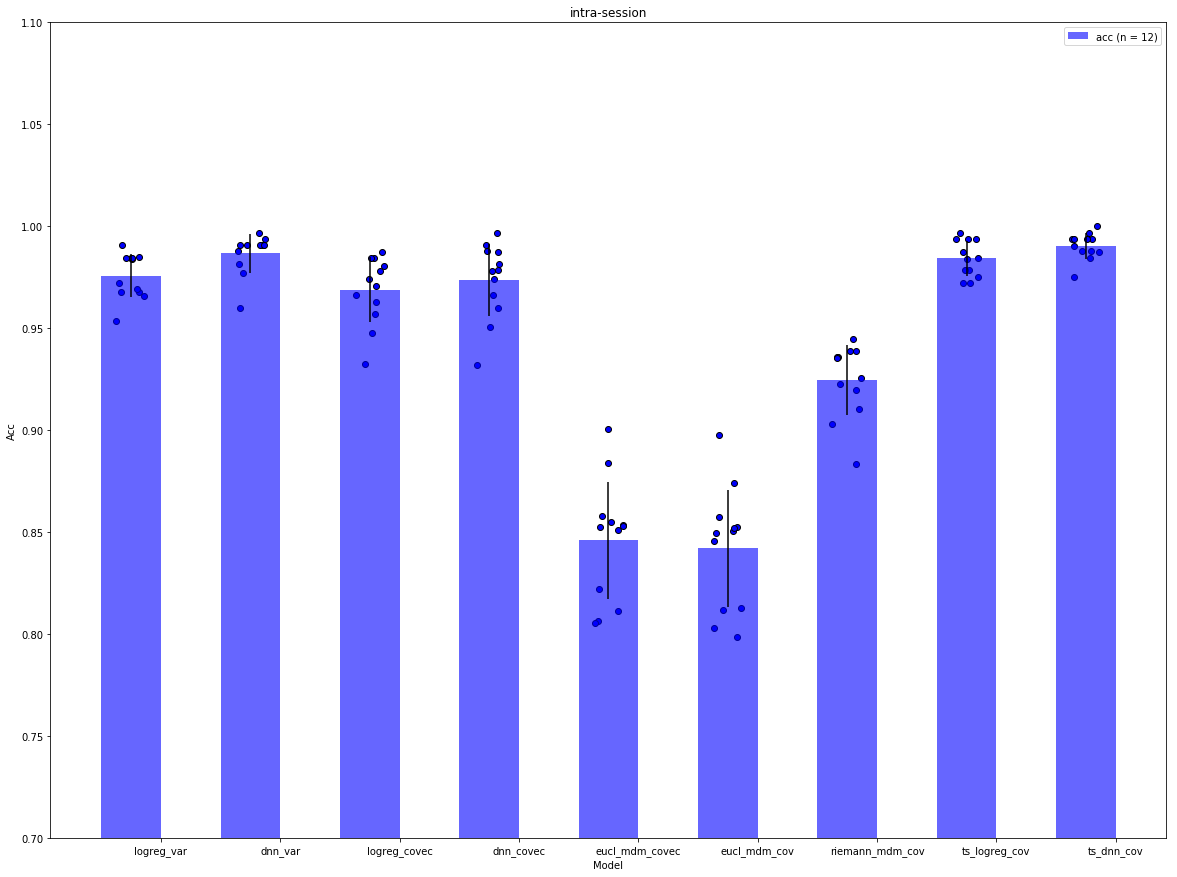

In [69]:
viz.bar_plot_scatter_comp([acc_var], model_labels, 'intra-session', ['acc'])
plt.ylim([0.7, 1.1])

# 5. Model on Inter-session

## 5.1 Euclidean MDM

In [50]:
result_intersess = {}

In [51]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, hf.ClosestMean(), key_result='eucl_mdm', data_type='cov')

mg*s1* mg*s2* 0.6462167689161554
mg*s2* mg*s1* 0.706766917293233
rr*s1* rr*s2* 0.5102669404517454
rr*s2* rr*s1* 0.7954779033915724
avg: 0.6646821325131766


## 5.2 Riemann MDM

In [125]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, pyriemann.classification.MDM(), key_result='riemann_mdm', data_type='cov')

mg*s1* mg*s2* 0.6339468302658486
mg*s2* mg*s1* 0.44575725026852847
rr*s1* rr*s2* 0.6837782340862423
rr*s2* rr*s1* 0.7841726618705036
avg: 0.6369137441227808


## 5.3 Log Reg on cov

In [126]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, LogisticRegression(solver='lbfgs', multi_class='multinomial'), key_result='logrec_covec', data_type='covec')

/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


mg*s1* mg*s2* 0.7157464212678937
mg*s2* mg*s1* 0.4189044038668099
rr*s1* rr*s2* 0.7053388090349076
rr*s2* rr*s1* 0.7821171634121274
avg: 0.6555266993954346


/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## 5.4 Tangeant + Log Reg

In [127]:
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('ts', TangentSpace()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_tang_lr = Pipeline(estimators)

In [128]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, pipeline_tang_lr, key_result='ts_logrec_cov', data_type='cov')

mg*s1* mg*s2* 0.7310838445807771
mg*s2* mg*s1* 0.5875402792696026
rr*s1* rr*s2* 0.6930184804928131
rr*s2* rr*s1* 0.9044193216855088
avg: 0.7290154815071754


## 5.5 DNN on Cov

In [129]:
# Function to create model, required for KerasClassifier
def create_model_covariance(weights='initial_weights.hd5'):
    return create_model(weights=weights, n_features=36)
generate_weights = create_model_covariance(weights=None)

In [130]:
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('ts', TangentSpace()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model_covariance, epochs=100, verbose=0)))
pipeline_tang_dnn = Pipeline(estimators)

In [131]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, pipeline_tang_dnn, key_result='ts_dnn_cov', data_type='cov')

mg*s1* mg*s2* 0.7034764826175869
mg*s2* mg*s1* 0.5639097744360902
rr*s1* rr*s2* 0.7720739219712526
rr*s2* rr*s1* 0.9362795477903392
avg: 0.7439349317038172


## 5.6 Tangeant + DNN

In [132]:
# Function to create model, required for KerasClassifier
def create_model_covariance(weights='initial_weights.hd5'):
    return create_model(weights=weights, n_features=36)
generate_weights = create_model_covariance(weights=None)

In [133]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, KerasClassifier(build_fn=create_model_covariance, epochs=100, verbose=0), key_result='dnn_covec', data_type='covec')

mg*s1* mg*s2* 0.7392638036809815
mg*s2* mg*s1* 0.5585392051557465
rr*s1* rr*s2* 0.7104722792607803
rr*s2* rr*s1* 0.8201438848920863
avg: 0.7071047932473986


Seems that the Log Reg (with eventually a projection on the Tangeant Space) is the best algorithm so far for inter-session accuracy

In [134]:
acc_inter = np.array([list(model['acc'].values()) for key, model in result_intersess.items()]).transpose()[0]
model_labels = [x for x in result_intersess.keys()]

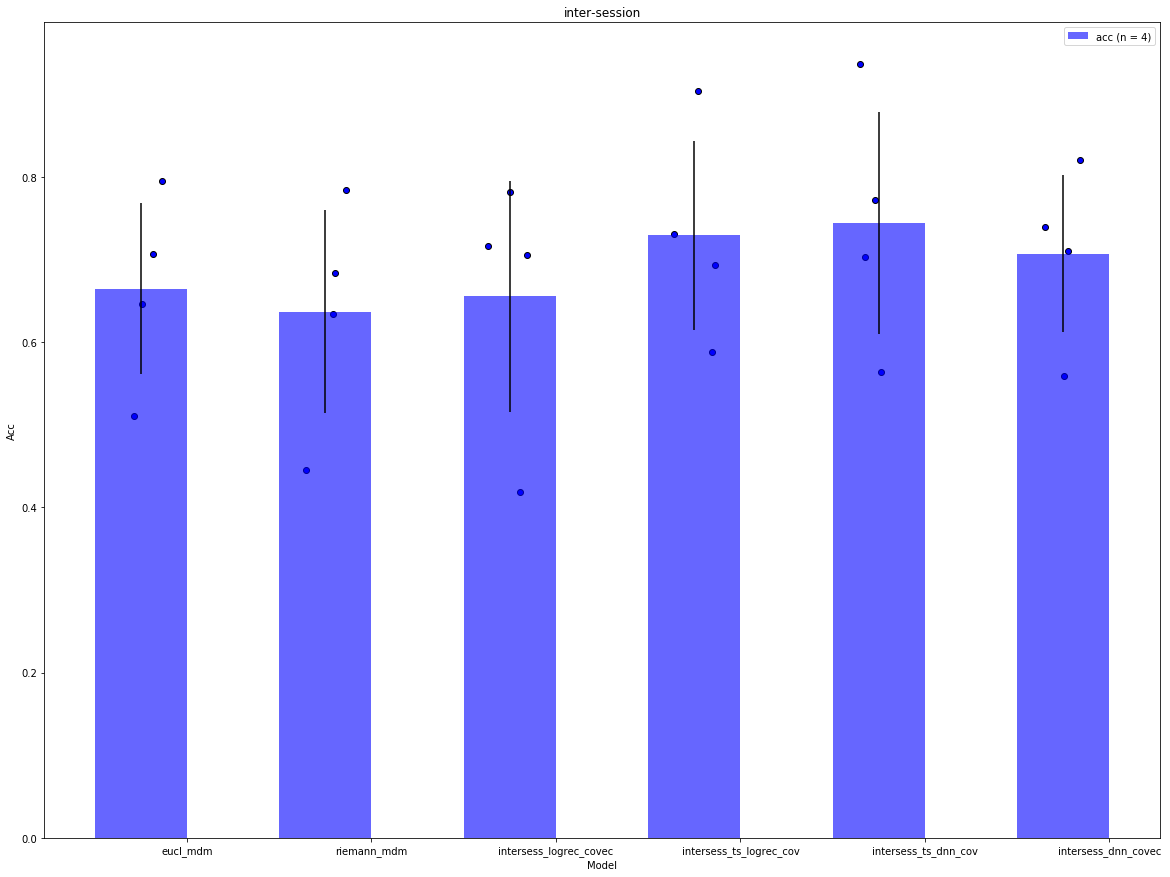

In [135]:
viz.bar_plot_scatter_comp([acc_inter], model_labels, 'inter-session', ['acc'])
#plt.ylim([0.7, 1.1])

# 6. Model on Inter-subjects

In [71]:
result_subj = {}

## 6.1 Euclidean MDM

In [72]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, hf.ClosestMean(), key_result='mdm_eucl')

mg*s1* rr*s1* 0.25488180883864336
mg*s1* rr*s2* 0.2587268993839836
mg*s2* rr*s1* 0.26618705035971224
mg*s2* rr*s2* 0.27618069815195073
rr*s1* mg*s1* 0.2964554242749731
rr*s1* mg*s2* 0.49897750511247446
rr*s2* mg*s1* 0.4414607948442535
rr*s2* mg*s2* 0.6175869120654397
avg: 0.36380713662892883


## 6.2 Riemann MDM

In [73]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, pyriemann.classification.MDM(), key_result='mdm_riemann')

mg*s1* rr*s1* 0.23741007194244604
mg*s1* rr*s2* 0.25770020533880905
mg*s2* rr*s1* 0.3823227132579651
mg*s2* rr*s2* 0.41683778234086244
rr*s1* mg*s1* 0.2953813104189044
rr*s1* mg*s2* 0.4233128834355828
rr*s2* mg*s1* 0.21267454350161116
rr*s2* mg*s2* 0.5184049079754601
avg: 0.34300555227645513


## 6.3 Log Reg on cov

In [74]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, LogisticRegression(solver='lbfgs', multi_class='multinomial'), key_result='log_covec', data_type='covec')

mg*s1* rr*s1* 0.4244604316546763
mg*s1* rr*s2* 0.6416837782340863
mg*s2* rr*s1* 0.34121274409044194
mg*s2* rr*s2* 0.3131416837782341


/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


rr*s1* mg*s1* 0.4070891514500537
rr*s1* mg*s2* 0.5899795501022495
rr*s2* mg*s1* 0.47261009667024706
rr*s2* mg*s2* 0.6728016359918201
avg: 0.4828723839964761


/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## 6.4 Tangeant + Log Reg

In [76]:
estimators = []
estimators.append(('ts', TangentSpace()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_tang_lr = Pipeline(estimators)

In [77]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, pipeline_tang_lr, key_result='ts_log')

mg*s1* rr*s1* 0.17163412127440905
mg*s1* rr*s2* 0.25051334702258726
mg*s2* rr*s1* 0.24049331963001028
mg*s2* rr*s2* 0.2515400410677618
rr*s1* mg*s1* 0.2900107411385607
rr*s1* mg*s2* 0.7280163599182005
rr*s2* mg*s1* 0.4296455424274973
rr*s2* mg*s2* 0.6789366053169734
avg: 0.3800987597245


## 6.5 DNN on Cov

In [78]:
# Function to create model, required for KerasClassifier
def create_model(weights='initial_weights.hd5'):
    # Create model.
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(34, activation='relu', input_shape=(36,)),
    tf.keras.layers.Dense(17, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])
    # Compile model
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    if weights is None:
        model.save_weights('initial_weights.hd5')
    else:
        model.load_weights(weights)
    return model

In [79]:
generate_weights = create_model(weights=None)

W0602 21:24:25.707840 139948931426048 deprecation.py:506] From /home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [80]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, KerasClassifier(build_fn=create_model, epochs=100, verbose=0), key_result='dnn_covec', data_type='covec')

mg*s1* rr*s1* 0.3895169578622816
mg*s1* rr*s2* 0.7361396303901437
mg*s2* rr*s1* 0.39568345323741005
mg*s2* rr*s2* 0.3162217659137577
rr*s1* mg*s1* 0.41245972073039744
rr*s1* mg*s2* 0.6073619631901841
rr*s2* mg*s1* 0.41353383458646614
rr*s2* mg*s2* 0.6431492842535788
avg: 0.48925832627052745


## 6.6 Tangeant + DNN

In [81]:
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('ts', TangentSpace()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model, epochs=100, verbose=0)))
pipeline_tang_dnn = Pipeline(estimators)

In [82]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, pipeline_tang_dnn, key_result='ts_dnn')

mg*s1* rr*s1* 0.28776978417266186
mg*s1* rr*s2* 0.25564681724845995
mg*s2* rr*s1* 0.22816032887975335
mg*s2* rr*s2* 0.24948665297741274
rr*s1* mg*s1* 0.34371643394199786
rr*s1* mg*s2* 0.7515337423312883
rr*s2* mg*s1* 0.3952738990332975
rr*s2* mg*s2* 0.6901840490797546
avg: 0.4002214634580783


# Plotting

In [83]:
acc_subj = np.array([model['acc'] for key, model in result_subj.items()]).transpose()
model_labels = [x for x in result_subj.keys()]

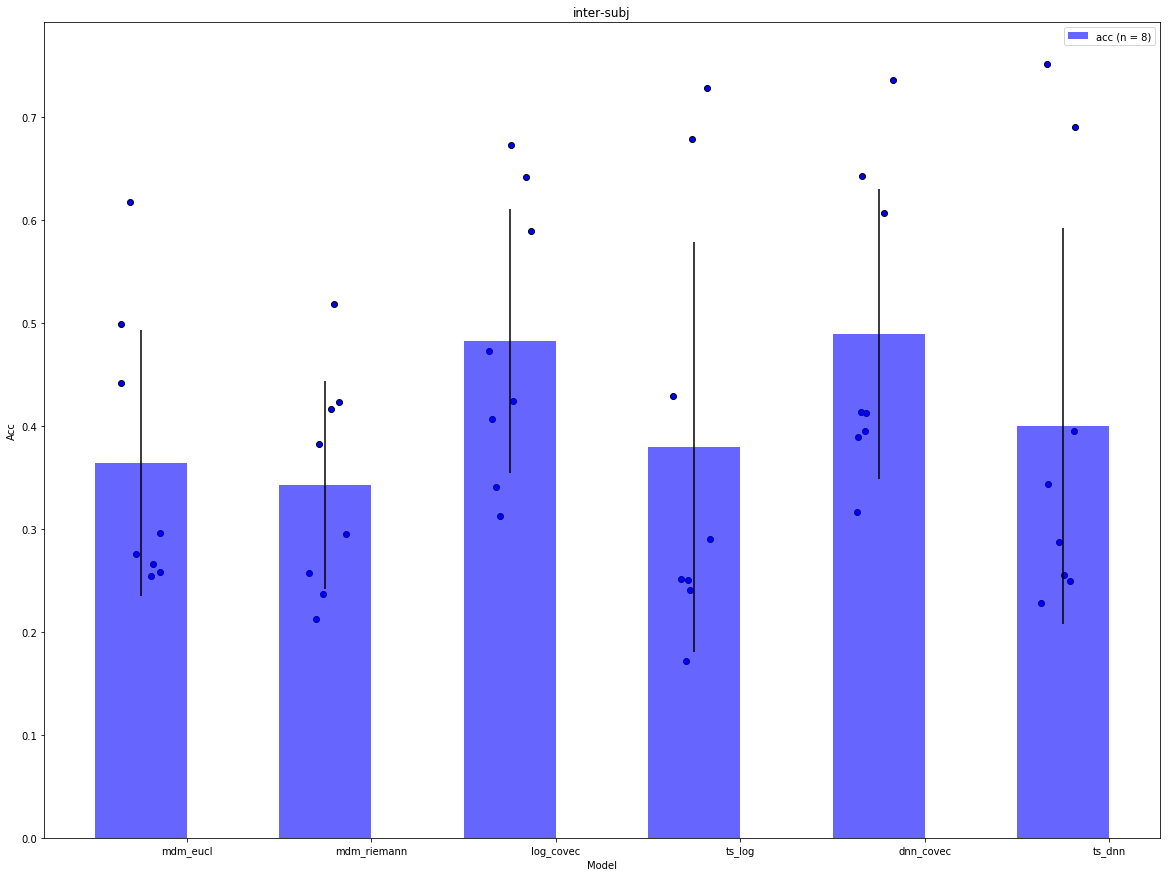

In [84]:
viz.bar_plot_scatter_comp([acc_subj], model_labels, 'inter-subj', ['acc'])